# Introducción a los sistemas de recomendación

## Objetivos de la sesión
* Aprender sobre los sistemas de recomendación.
* Definir un primer filtrado colaborativo.
* Visualizar las valoraciones de los usuarios en un espacio de preferencias general.
* Calcular similitudes entre usuarios en el espacio de preferencias.
* Utilizar puntuaciones de similitud para la ponderación.
* Clasificar las calificaciones ponderadas para producir recomendaciones.

## Introducción
Los sistemas de recomendación son una parte fundamental del mundo digital actual. Se utilizan para personalizar la experiencia que un usuario tiene con un sitio web o una aplicación, haciéndola más útil para el usuario. Algunas de las compañías más prominentes de hoy en día tienen sistemas de recomendación en el centro de la experiencia del cliente.

Amazon recomienda productos basados en compras de productos anteriores, valoraciones y las compras/valoraciones de otros clientes similares a nosotros.
Netflix recomienda películas basadas en las películas que hemos visto, nuestras calificaciones y el comportamiento de otros usuarios similares a nosotros.
Facebook, Twitter y LinkedIn recomiendan a personas que quizás ya conozcamos en base a nuestras conexiones y a las conexiones de aquellos con los que estamos conectados, y también usan esta información para personalizar nuestra fuente de noticias.
En esta lección, aprenderemos los fundamentos de los sistemas de recomendación, cómo funcionan y cómo crear un sistema de filtrado básico basado en el usuario usando Python.

## Filtrado colaborativo
Antes de que existieran los sistemas de recomendación, la forma principal de obtener recomendaciones sobre cosas como películas o productos era preguntar a tus amigos. A medida que seguíamos sus recomendaciones, nos hacíamos una idea de qué amigos tenían gustos más similares a los nuestros y confiábamos en sus recomendaciones con más frecuencia. Sin embargo, a medida que el número de opciones disponibles ha aumentado drásticamente en las últimas décadas, se ha hecho cada vez más difícil confiar en las recomendaciones de un pequeño grupo de amigos, ya que también es cada vez más probable que ellos no conozcan todas las opciones disponibles. La solución para esto fue un método llamado filtrado colaborativo.

El filtrado colaborativo nos proporciona una forma de hacer predicciones automáticas (filtrado) sobre los intereses de un usuario recogiendo las preferencias de muchos usuarios (colaboración). La suposición subyacente es que si dos personas tienen la misma opinión sobre un tema, es probable que también tengan una opinión similar sobre otros temas. Hay algunas maneras diferentes de enfocar el filtrado colaborativo, pero en términos generales, implican encontrar un grupo de personas similares a un usuario, analizar las cosas que les gustan y crear una lista clasificada de recomendaciones para el usuario.

## Similitud entre usuarios
La similitud entre los usuarios está en el centro del filtrado colaborativo. Para hacer buenas recomendaciones, necesitamos saber qué tan parecidos son dos usuarios. La manera de hacer esto es comparando cuán similares han sido sus valoraciones para el mismo producto. Por ejemplo, importemos el archivo [movie_ratings.csv](https://s3-eu-west-1.amazonaws.com/ih-materials/uploads/data-static/data/module-2/movie_ratings.csv).

In [1]:
import pandas as pd
%matplotlib inline

ratings = pd.read_csv('./data/movie_ratings.csv').set_index('Movie')

Este cuadro de datos contiene 10 películas y clasificaciones de 5 usuarios en una escala de 1 (no les gustó) a 5 (les encantó).

In [2]:
ratings.head()

,Brandon,Emily,Cleo,Rusty,Samantha
Movie,,,,,
Aquaman,4,1,2,2,2
Avengers: Infinity War,2,5,2,5,5
Black Panther,5,2,5,1,1
Bohemian Rhapsody,2,3,4,4,1
Deadpool 2,3,2,4,5,1


Si quisiéramos echar un vistazo a las valoraciones de los usuarios en el espacio de preferencias de dos películas, podríamos definir una función que acepte dos títulos de películas y trazar gráficas de dispersión de las valoraciones de los usuarios de la siguiente manera.

In [3]:
def ratings_scatter(movie1, movie2):
    import matplotlib.pyplot as plt
    x = ratings.T[movie1]
    y = ratings.T[movie2]
    n = list(ratings.T.index)

    fig, ax = plt.subplots()
    ax.scatter(x, y, s=0)
    fig.set_figwidth(12)
    fig.set_figheight(8)
    plt.title("Preference Space for "+ movie1 + " vs. " + movie2, fontsize=20)
    ax.set_xlabel(movie1, fontsize=16)
    ax.set_ylabel(movie2, fontsize=16) 

    for i, txt in enumerate(n):
        ax.annotate(txt, (x[i], y[i]), fontsize=12)

Entonces, sólo tendríamos que elegir dos títulos y generar la gráfica para visualizar el espacio de preferencia de los usuarios en esas dos películas. Por ejemplo, a continuación se muestra el espacio de preferencia entre las películas Venom e Incredibles 2.

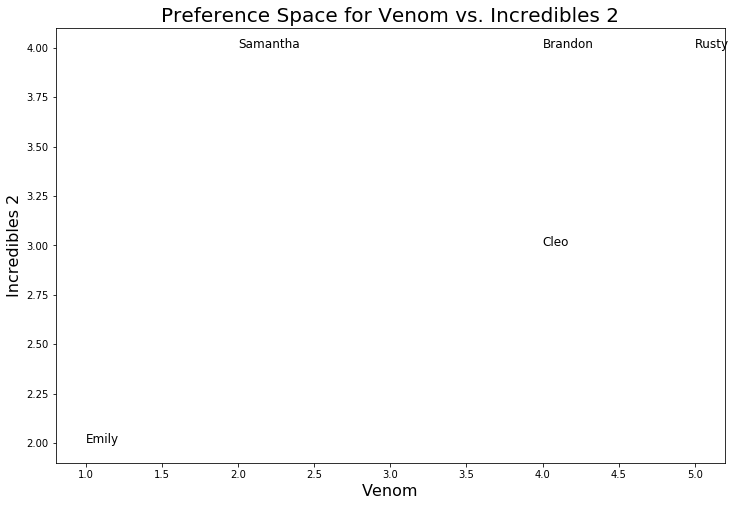

In [4]:
ratings_scatter('Venom', 'Incredibles 2')

Podemos ver que a través de este espacio de preferencia, Rusty se parece más a Brandon que a Emily. Sin embargo, esto puede variar entre diferentes sets de películas. Si en lugar de eso, graficamos las clasificaciones de Bohemian Rhapsody y Jurassic World, Rusty se parece más a Emily que a Brandon en este espacio de preferencia.

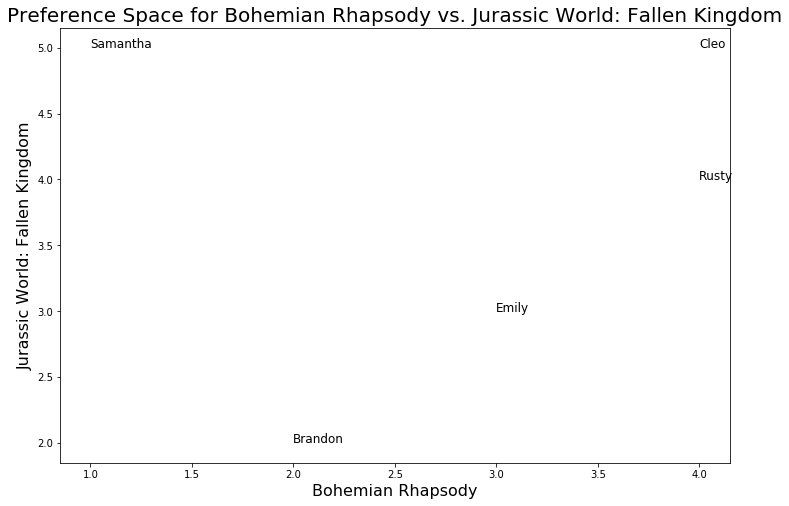

In [5]:
ratings_scatter('Bohemian Rhapsody', 'Jurassic World: Fallen Kingdom')

Para obtener la distancia agregada a través de todos los espacios de preferencia, podemos usar las funciones `squareform` y `pdist` de la biblioteca `Scipy` y así crear una matriz que contenga las distancias euclidianas entre todos nuestros usuarios.

In [19]:
from scipy.spatial.distance import pdist, squareform

squareform(pdist(ratings.T, 'euclidean'))


array([[0.        , 6.63324958, 6.        , 7.41619849, 7.48331477,
        5.38516481],
       [6.63324958, 0.        , 6.92820323, 6.40312424, 5.09901951,
        6.40312424],
       [6.        , 6.92820323, 0.        , 5.56776436, 8.24621125,
        3.60555128],
       [7.41619849, 6.40312424, 5.56776436, 0.        , 6.70820393,
        6.92820323],
       [7.48331477, 5.09901951, 8.24621125, 6.70820393, 0.        ,
        7.54983444],
       [5.38516481, 6.40312424, 3.60555128, 6.92820323, 7.54983444,
        0.        ]])

Estas distancias son más pequeñas para los usuarios que son más similares, pero para nuestros propósitos sería preferible tener una puntuación más alta para los usuarios que son más similares y una puntuación más baja para los usuarios que son menos similares. Podemos conseguirlo fácilmente añadiendo 1 a las puntuaciones e invirtiéndolas. También vamos a importarlos a un conjunto de datos para que podamos verlos y analizarlos más fácilmente.

In [7]:
distances = pd.DataFrame(1/(1 + squareform(pdist(ratings.T, 'euclidean'))), 
                         index=ratings.columns, columns=ratings.columns)

distances

,Brandon,Emily,Cleo,Rusty,Samantha
Brandon,1.000000,0.131006,0.142857,0.118818,0.117878
Emily,0.131006,1.000000,0.126132,0.135078,0.163961
Cleo,0.142857,0.126132,1.000000,0.152259,0.108152
Rusty,0.118818,0.135078,0.152259,1.000000,0.129732
Samantha,0.117878,0.163961,0.108152,0.129732,1.000000


## Creación de recomendaciones para un usuario
Supongamos que tenemos un nuevo usuario llamado Tom que vino a nosotros con las siguientes clasificaciones para cada película.

In [8]:
tom = {'Aquaman': 2,
 'Avengers: Infinity War': 1,
 'Black Panther': 5,
 'Bohemian Rhapsody': 5,
 'Deadpool 2': 2,
 'Fantastic Beasts: The Crimes of Grindelwald': 3,
 'Incredibles 2': 3,
 'Jurassic World: Fallen Kingdom': 4,
 'Mission: Impossible – Fallout': 3,
 'Venom': 3}

Podríamos incluir a Tom en nuestra matriz de similitud y luego determinar qué otros usuarios son más similares a él.

In [9]:
ratings['Tom'] = pd.Series(tom)

distances = pd.DataFrame(1/(1 + squareform(pdist(ratings.T, 'euclidean'))), 
                         index=ratings.columns, columns=ratings.columns)

similarities = distances['Tom'].sort_values(ascending=False)[1:]
similarities



Cleo        0.217129
Brandon     0.156613
Emily       0.135078
Rusty       0.126132
Samantha    0.116961
Name: Tom, dtype: float64

Parece que Cleo es la usuaria más parecida a Tom, seguida de Brandon, Emily, Rusty y luego Samantha. Estas puntuaciones de similitud deben ser tomadas en consideración cuando se le recomiendan películas a Tom que aún no haya visto.

Digamos que todo el mundo, excepto Tom, también calificó las películas en el archivo [movie_ratings2.csv](https://s3-eu-west-1.amazonaws.com/ih-materials/uploads/data-static/data/module-2/movie_ratings2.csv). Vamos a importar esas clasificaciones y luego combinarlas con las puntuaciones de similitud para generar recomendaciones de películas para Tom.

In [10]:
new_ratings = pd.read_csv('./data/movie_ratings2.csv').set_index('Movie')

Una vez que tengamos nuestra tabla de datos new_ratings, vamos a copiarla a una tabla de datos de nuevas recomendaciones sobre la que realizaremos nuestros cálculos.

In [24]:
recommendations = new_ratings.copy()
recommendations.head()

,Brandon,Emily,Cleo,Rusty,Samantha
Movie,,,,,
Beauty and the Beast,2,5,2,5,2
Despicable Me 3,4,5,5,1,2
Guardians of the Galaxy Vol. 2,4,1,5,4,2
Jumanji: Welcome to the Jungle,4,3,3,2,5
Spider-Man: Homecoming,1,3,5,2,5


Vamos a iterar a través de las puntuaciones de similitud de cada uno de los otros usuarios con Tom y ponderar sus recomendaciones de estas nuevas películas por su puntuación de similitud. Luego vamos a crear una nueva columna Total que resuma las puntuaciones totales de cada película y las clasificaremos de manera que las películas estén en el orden en que deben ser recomendadas a Tom.

In [12]:
for name, score in dict(similarities).items():
    recommendations[name] = recommendations[name] * score

recommendations['Total'] = recommendations.sum(axis=1)
recommendations.sort_values('Total', ascending=False)

,Brandon,Emily,Cleo,Rusty,Samantha,Total
Movie,,,,,,
Despicable Me 3,0.626452,0.675391,1.085646,0.126132,0.233923,2.747544
Wonder Woman,0.626452,0.405234,0.868517,0.378396,0.467845,2.746445
Thor: Ragnarok,0.626452,0.405234,0.868517,0.126132,0.584807,2.611142
Guardians of the Galaxy Vol. 2,0.626452,0.135078,1.085646,0.504528,0.233923,2.585627
Jumanji: Welcome to the Jungle,0.626452,0.405234,0.651388,0.252264,0.584807,2.520145
Spider-Man: Homecoming,0.156613,0.405234,1.085646,0.252264,0.584807,2.484564
Wolf Warrior 2,0.783065,0.405234,0.434259,0.378396,0.467845,2.468799
Beauty and the Beast,0.313226,0.675391,0.434259,0.630660,0.233923,2.287458
Star Wars: The Last Jedi,0.783065,0.540312,0.217129,0.252264,0.233923,2.026693


De estos resultados, parece que a Tom le gustaría Despicable Me 3, Wonder Woman y Thor, pero quizás no Star Wars o The Fate of the Furious.

## Usando Métricas de Similitudes Diferentes
Ahora que hemos generado un conjunto inicial de recomendaciones, hay un tema importante que nos gustaría comentar. Cuando calculamos nuestras métricas de similitud de usuario, utilizamos la distancia euclídea como nuestra métrica de distancia. Es importante señalar que existen otras métricas de distancia en Scipy que podríamos utilizar para obtener resultados diferentes. Una lista completa de todos los disponibles se puede encontrar [aquí](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html).

Para comprobar cómo son las recomendaciones utilizando una métrica de distancia diferente, todo lo que tenemos que hacer es cambiar el nombre de la métrica de la primera línea de código que aparece a continuación. Por ejemplo, si quisiéramos usar la distancia del coseno en su lugar, los resultados se verían así.

In [13]:
distances = pd.DataFrame(1/(1 + squareform(pdist(ratings.T, 'cosine'))), 
                         index=ratings.columns, columns=ratings.columns)

similarities = distances['Tom'].sort_values(ascending=False)[1:]

recommendations = new_ratings.copy()

for name, score in dict(similarities).items():
    recommendations[name] = recommendations[name] * score
    
recommendations['Total'] = recommendations.sum(axis=1)
recommendations.sort_values('Total', ascending=False)

,Brandon,Emily,Cleo,Rusty,Samantha,Total
Movie,,,,,,
Wonder Woman,3.615951,2.511274,3.809728,2.532334,3.168375,15.637662
Despicable Me 3,3.615951,4.185457,4.762161,0.844111,1.584187,14.991867
Thor: Ragnarok,3.615951,2.511274,3.809728,0.844111,3.960468,14.741533
Wolf Warrior 2,4.519939,2.511274,1.904864,2.532334,3.168375,14.636786
Jumanji: Welcome to the Jungle,3.615951,2.511274,2.857296,1.688222,3.960468,14.633212
Guardians of the Galaxy Vol. 2,3.615951,0.837091,4.762161,3.376445,1.584187,14.175835
Spider-Man: Homecoming,0.903988,2.511274,4.762161,1.688222,3.960468,13.826113
Beauty and the Beast,1.807976,4.185457,1.904864,4.220556,1.584187,13.703040
Star Wars: The Last Jedi,4.519939,3.348365,0.952432,1.688222,1.584187,12.093146


Podemos ver que Wonder Woman está ahora en lo más alto de la lista, Guardians of the Galaxy cayó unos cuantos lugares, y Wolf Warrior se arrastró hasta el puesto número 4.

Si en lugar de eso probamos la distancia cityblock, Guardians of the Galaxy sube hasta el número 3 y Spider-Man se coloca entre los 5 primeros.

## Resumen
En esta lección, hemos realizado una introducción a los sistemas de recomendación y hemos echado un vistazo a cómo podemos crear un recomendador de filtrado basado en el usuario. A lo largo del camino, hemos visualizado los espacios de preferencia del usuario para pares de películas, hemos calculado las puntuaciones de similitud entre grupos de usuarios y hemos combinado esas puntuaciones de similitud con las puntuaciones para clasificar las películas de modo que podamos recomendarlas a un usuario en particular. Esto es sólo la punta del iceberg cuando se trata de sistemas de recomendación, pero esperamos que esta lección haya dado una idea de cómo funcionan estos tipos de sistemas y cómo podríamos armar uno propio.